In [4]:
import io, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

## Data Source

* ChinaBond https://yield.chinabond.com.cn/cbweb-mn/
* Date: 2025-09-12
* Download Link https://yield.chinabond.com.cn/cbweb-mn/yc/downBzqxDetail?dxbj=&locale=zh_CN&qxlx=&workTime=2025-09-12&wrjxCBFlag=0&ycDefIds=2c9081e50a2f9606010a3068cae70001&yqqxK=&yqqxN=&zblx=txy



In [7]:
DATE  = "2025-09-12"
YC_ID = "2c9081e50a2f9606010a3068cae70001"

def get_data(date=DATE, yc_id=YC_ID):
    url = ("https://yield.chinabond.com.cn/cbweb-mn/yc/downBzqxDetail"
           f"?dxbj=&locale=zh_CN&qxlx=&workTime={date}&wrjxCBFlag=0"
           f"&ycDefIds={yc_id}&yqqxK=&yqqxN=&zblx=txy")
    content = requests.get(url, timeout=30).content
    df = pd.read_excel(io.BytesIO(content))
    df = df.rename(columns={'标准期限(年)': 'term', '收益率(%)': 'yield'})
    for col in ['曲线名称', '到期收益率', '期限(年)']:
        if col in df.columns:
            df = df.drop(columns=[col])
    df = df[['term', 'yield']].dropna().sort_values('term').reset_index(drop=True)
    return df

df = get_data()
mask = (df['term'] >= 0.5) & (df['term'] <= 30)
df_fit = df.loc[mask].reset_index(drop=True)

t = df_fit['term'].values.astype(float)
y = (df_fit['yield'].values / 100.0).astype(float)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


NS params: beta0=0.024020, beta1=-0.009813, beta2=-0.012561, lambda=2.386007
NS   fit error: RMSE=0.000216, MAE=0.000146
Spline fit error: RMSE=0.000000, MAE=0.000000


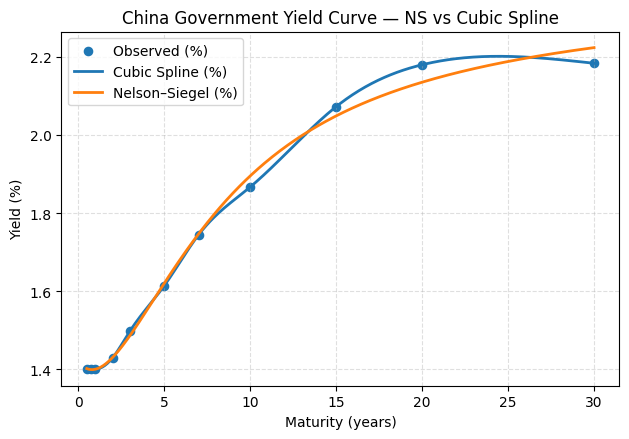

In [5]:
def nelson_siegel(t, b0, b1, b2, lam):
    t = np.asarray(t, dtype=float)
    eps = 1e-8
    x = t / (lam + eps)
    e = np.exp(-x)
    L1 = (1 - e) / (x + eps)
    L2 = L1 - e
    return b0 + b1 * L1 + b2 * L2

y_long = np.median(y[-5:]) if len(y) >= 5 else y[-1]
y_short = y[0]
p0 = [y_long, y_short - y_long, 0.0, 1.5]
bounds = ([-0.05, -0.20, -0.20, 1e-4],
          [ 0.20,  0.20,  0.20, 50.0])

popt, pcov = curve_fit(nelson_siegel, t, y, p0=p0, bounds=bounds, maxfev=100000)
b0, b1, b2, lam = popt
y_ns_fit = nelson_siegel(t, *popt)
rmse_ns = np.sqrt(np.mean((y - y_ns_fit)**2))
mae_ns  = np.mean(np.abs(y - y_ns_fit))

# === Cubic Spline (interpolating, natural BC) ===
cs = CubicSpline(t, y, bc_type='natural')
y_sp_fit = cs(t)
rmse_sp = np.sqrt(np.mean((y - y_sp_fit)**2))
mae_sp  = np.mean(np.abs(y - y_sp_fit))

# === print metrics ===
print(f"NS params: beta0={b0:.6f}, beta1={b1:.6f}, beta2={b2:.6f}, lambda={lam:.6f}")
print(f"NS   fit error: RMSE={rmse_ns:.6f}, MAE={mae_ns:.6f}")
print(f"Spline fit error: RMSE={rmse_sp:.6f}, MAE={mae_sp:.6f}")

# === plot both models in one figure ===
t_dense = np.linspace(t.min(), t.max(), 400)
y_ns_dense = nelson_siegel(t_dense, *popt)
y_sp_dense = cs(t_dense)

plt.figure(figsize=(7.2, 4.6))
plt.scatter(t, y*100, s=35, label='Observed (%)')
plt.plot(t_dense, y_sp_dense*100, lw=2, label='Cubic Spline (%)')
plt.plot(t_dense, y_ns_dense*100, lw=2, label='Nelson–Siegel (%)')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.title('China Government Yield Curve — NS vs Cubic Spline')
plt.legend()
plt.grid(True, ls='--', alpha=0.4)
plt.show()

## Model Comparision

### Fit
*   Cubic Spline model is constrcted to pass exactly through all observed points, so it's perfect fit (RMSE/MAE = 0 is within expectation)
*   Nelson-Siegel also has very small error. Slightly less tight in sample, but smoother and more robust than cubic spline

### Interpretaion
*   Nelson-Siegel's parameters are economic meaniful
1.  beta0=0.024020 is the level parameter indicates a long-term rate
2.  beta1=-0.009813 less than 0 is the slope parameter indicates a upward-sloping curve
3. beta2=-0.012561 less than 0 means a mild hump
4. and lambda=2.386007 is the decay scale

*  Cubic spline has many cubic coefficients with no direct economic meaning. It's good for plotting but weak for factor/style interpretation










## If Nelson-Siegel is smoothing the yield curve, is this considered unethical?

It's really depend on the intent and transparency. Simply fitting a reproducible curve to data for summary purpose isn't usually unethical. However, it would be unethic to mislead stakeholders by hiding inconvenient data - such as kinks, periods of illiquidity, or stress, or by failing to disclose that raw data points have been dropped. Furthermore, if the explicit purpose is to misrepresent the information for dishonest reasons, it should be absolutely prohibited